<a href="https://colab.research.google.com/github/Seyed-Ali-Ahmadi/Python-for-Remote-Sensing/blob/master/Sentinel_1_OWI_product.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install NetCDF4 package
!pip install netcdf4

In [0]:
# install Cartopy package
!apt-get -qq install python-cartopy python3-cartopy

In [0]:
import zipfile as zf
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [4]:
# Opening the Sentinel-1 OCN product...
file_name = '/content/S1A_IW_OCN__2SDV_20190718T212220_20190718T212245_028177_032EC9_AF8E.zip'

with zf.ZipFile(file_name, 'r') as zip:
  # Extract the file in the current directory.
  zip.extractall()
  # Print all containing files and folders.
  zip.printdir()

File Name                                             Modified             Size
S1A_IW_OCN__2SDV_20190718T212220_20190718T212245_028177_032EC9_AF8E.SAFE/ 2019-07-19 02:16:34            0
S1A_IW_OCN__2SDV_20190718T212220_20190718T212245_028177_032EC9_AF8E.SAFE/support/ 2019-07-19 02:16:34            0
S1A_IW_OCN__2SDV_20190718T212220_20190718T212245_028177_032EC9_AF8E.SAFE/support/s1-object-types.xsd 2019-07-19 02:16:34        60608
S1A_IW_OCN__2SDV_20190718T212220_20190718T212245_028177_032EC9_AF8E.SAFE/support/s1-map-overlay.xsd 2019-07-19 02:16:34          450
S1A_IW_OCN__2SDV_20190718T212220_20190718T212245_028177_032EC9_AF8E.SAFE/support/s1-product-preview.xsd 2019-07-19 02:16:34          440
S1A_IW_OCN__2SDV_20190718T212220_20190718T212245_028177_032EC9_AF8E.SAFE/support/s1-level-2-measurement.xsd 2019-07-19 02:16:34          471
S1A_IW_OCN__2SDV_20190718T212220_20190718T212245_028177_032EC9_AF8E.SAFE/S1A_IW_OCN__2SDV_20190718T212220_20190718T212245_028177_032EC9_AF8E.SAFE-report-

In [5]:
# Accessing the OWI sub-product.
nc_file = '/content/S1A_IW_OCN__2SDV_20190718T212220_20190718T212245_028177_032EC9_AF8E.SAFE/measurement/s1a-iw-ocn-vv-20190718t212127-20190718t212159-028177-032EC9-001.nc'
dataset = nc.Dataset(nc_file)

print(dataset.dimensions.keys())

odict_keys(['rvlRaSize', 'length', 'rvlAzSize', 'rvlSwath', 'owiRaSize', 'owiAzSize', 'owiIncSize', 'owiPolarisation', 'oswRaSize', 'oswAzSize', 'oswWavenumberBinSize', 'oswAngularBinSize', 'oswPartitions', 'oswKxBinSize', 'oswKyBinSize', 'oswLag'])


In [6]:
print(dataset.dimensions['owiAzSize'])
print(dataset.dimensions['owiRaSize'])
print(dataset.dimensions['owiIncSize'])
print(dataset.dimensions['owiPolarisation'])

<class 'netCDF4._netCDF4.Dimension'>: name = 'owiAzSize', size = 166

<class 'netCDF4._netCDF4.Dimension'>: name = 'owiRaSize', size = 255

<class 'netCDF4._netCDF4.Dimension'>: name = 'owiIncSize', size = 152

<class 'netCDF4._netCDF4.Dimension'>: name = 'owiPolarisation', size = 2



In [7]:
print(dataset.variables.keys())
print(dataset.variables['owiWindSpeed'])
print(dataset.variables['owiWindDirection'])

odict_keys(['oswPolSpec', 'oswPartitions', 'oswQualityCrossSpectraRe', 'oswQualityCrossSpectraIm', 'oswK', 'oswPhi', 'oswAzCutoff', 'oswRaCutoff', 'oswSpecRes', 'oswLon', 'oswLat', 'oswHs', 'oswWl', 'oswDirmet', 'oswSnr', 'oswAmbiFac', 'oswIconf', 'oswLookSeparationTime', 'oswNrcs', 'oswInten', 'oswNv', 'oswSkew', 'oswKurt', 'oswWindSpeed', 'oswWindDirection', 'oswEcmwfWindSpeed', 'oswEcmwfWindDirection', 'oswWindSeaHs', 'oswWaveAge', 'oswDepth', 'oswNlWidth', 'oswLandFlag', 'oswLandCoverage', 'oswIncidenceAngle', 'oswHeading', 'oswGroundRngSize', 'oswAziSize', 'oswEllipsLength', 'oswEllipsLengthStdDev', 'oswEllipsWidth', 'oswEllipsWidthStdDev', 'oswGroupDir', 'oswQualityFlagPartition', 'oswQualityFlag', 'oswTotalHs', 'oswCartSpecIm', 'oswCartSpecRe', 'oswKx', 'oswKy', 'oswJx', 'oswJy', 'owiHs', 'owiWl', 'owiDirmet', 'owiWindSeaHs', 'owiLon', 'owiLat', 'owiIncidenceAngle', 'owiElevationAngle', 'owiWindSpeed', 'owiWindDirection', 'owiEcmwfWindSpeed', 'owiEcmwfWindDirection', 'owiNrcs', 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


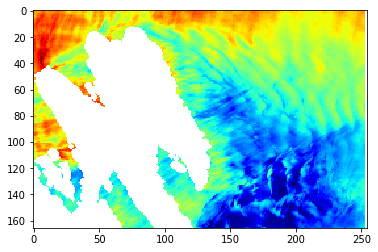

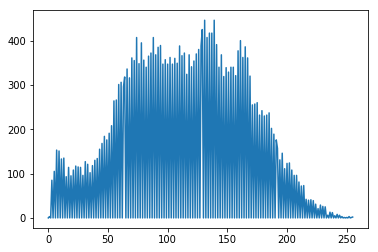

(<Figure size 432x288 with 1 Axes>,
 None)

In [8]:
owiSpeed = np.array(dataset.variables['owiWindSpeed'])
owiSpeed[owiSpeed == -999.] = np.nan

hist,bins = np.histogram(owiSpeed.ravel(),256,[0,13])

plt.figure(), plt.imshow(owiSpeed, cmap='jet'), plt.show()
plt.figure(), plt.plot(hist), plt.show()

In [9]:
lat = np.array(dataset.variables['owiLat'])
lon = np.array(dataset.variables['owiLon'])
print(lat)
print(lon)

[[46.37175  46.37347  46.37519  ... 46.760975 46.762333 46.76369 ]
 [46.380726 46.382446 46.384167 ... 46.769962 46.771324 46.77268 ]
 [46.3897   46.391426 46.393147 ... 46.77895  46.780308 46.781666]
 ...
 [47.835102 47.836838 47.838577 ... 48.224842 48.226196 48.22755 ]
 [47.844074 47.845814 47.84755  ... 48.233818 48.235176 48.23653 ]
 [47.85305  47.85479  47.856525 ... 48.242798 48.244156 48.245506]]
[[-54.10199  -54.089233 -54.076477 ... -50.863705 -50.85076  -50.837822]
 [-54.10455  -54.091793 -54.079033 ... -50.865734 -50.85279  -50.839848]
 [-54.107113 -54.094357 -54.081596 ... -50.867764 -50.85482  -50.841873]
 ...
 [-54.527348 -54.514236 -54.50113  ... -51.198616 -51.185314 -51.17201 ]
 [-54.529995 -54.516884 -54.503773 ... -51.20069  -51.187386 -51.17408 ]
 [-54.532646 -54.519535 -54.50642  ... -51.202766 -51.18946  -51.17615 ]]


/usr/local/lib/python3.6/dist-packages/matplotlib/ticker.py:1879: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


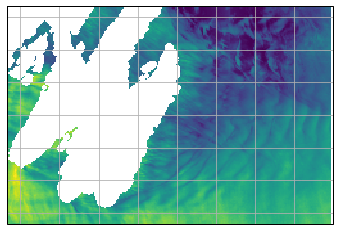

In [10]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines()
extent = [-60, -45, 50, 40]
ax.imshow(owiSpeed, extent=extent, transform=ccrs.PlateCarree())

In [11]:
lat = dataset.variables['owiLat'][:]
lon = dataset.variables['owiLon'][:]
print(lat)
print(lon)

[[46.37175  46.37347  46.37519  ... 46.760975 46.762333 46.76369 ]
 [46.380726 46.382446 46.384167 ... 46.769962 46.771324 46.77268 ]
 [46.3897   46.391426 46.393147 ... 46.77895  46.780308 46.781666]
 ...
 [47.835102 47.836838 47.838577 ... 48.224842 48.226196 48.22755 ]
 [47.844074 47.845814 47.84755  ... 48.233818 48.235176 48.23653 ]
 [47.85305  47.85479  47.856525 ... 48.242798 48.244156 48.245506]]
[[-54.10199  -54.089233 -54.076477 ... -50.863705 -50.85076  -50.837822]
 [-54.10455  -54.091793 -54.079033 ... -50.865734 -50.85279  -50.839848]
 [-54.107113 -54.094357 -54.081596 ... -50.867764 -50.85482  -50.841873]
 ...
 [-54.527348 -54.514236 -54.50113  ... -51.198616 -51.185314 -51.17201 ]
 [-54.529995 -54.516884 -54.503773 ... -51.20069  -51.187386 -51.17408 ]
 [-54.532646 -54.519535 -54.50642  ... -51.202766 -51.18946  -51.17615 ]]


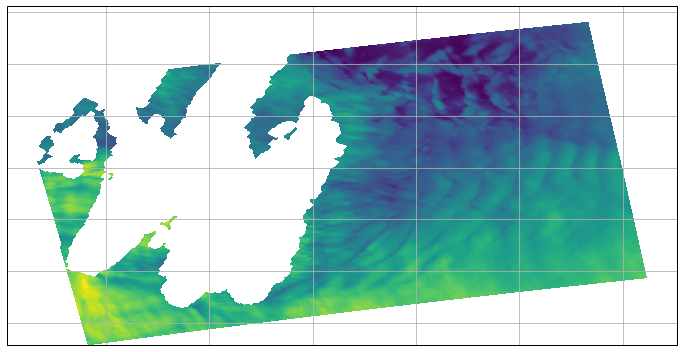

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines()
extent = [-59, -45, 50, 40]
ax.contourf(lon, lat, owiSpeed, 100, transform=ccrs.PlateCarree())